In [2]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA

ad_atac = anndata.read_h5ad('/home/yuanh/sc_basset/datasets/10x_ARC_PBMC/ad_atac.h5ad')
ad_rna = anndata.read_h5ad('/home/yuanh/sc_basset/datasets/10x_ARC_PBMC/scvi/ad_rna_scvi.h5ad')
ad_atac.obs['leiden_rna'] = ad_rna.obs['leiden'].values

# compute label score and neighbor score
def compute_metric(ad_rna, ad_atac, nn, label_obs_idx=1):
    # RNA neighbors
    sc.pp.neighbors(ad_rna, n_neighbors=nn+1, use_rep='scvi')
    m_RNA_neighbors = [i.indices for i in ad_rna.obsp['distances']] # neighbor idx for each cell
        
    # ATAC neighbors
    sc.pp.neighbors(ad_atac, n_neighbors=nn+1, use_rep='projection') # n nearest neighbor of each cell
    m_ATAC_neighbors = [i.indices for i in ad_atac.obsp['distances']] # neighbor idx for each cell

    # neighbor score
    n_shared_neighbors = np.mean([len(np.intersect1d(i,j)) for i,j in zip(m_RNA_neighbors, m_ATAC_neighbors)])

    # label score
    neighbor_label = ad_atac.obs.iloc[np.concatenate(m_ATAC_neighbors, axis=0), label_obs_idx] # label for all neighbors
    cell_label = ad_atac.obs.iloc[np.repeat(np.arange(len(m_ATAC_neighbors)), [len(j) for j in m_ATAC_neighbors]), label_obs_idx] # label for all cells
    n_shared_labels = (neighbor_label.values==cell_label.values).sum() / len(m_ATAC_neighbors)

    return n_shared_neighbors/nn, n_shared_labels/nn


In [2]:
z_motif = pd.read_csv('z_motif.csv', index_col=0)
z_kmer = pd.read_csv('z_kmer.csv', index_col=0)
z_motif.drop(z_motif.columns[227],axis=1,inplace=True) # exclude the tf with NA

In [3]:
pca = PCA(n_components=100) # PCA

embed = pca.fit_transform(z_motif.values)
pd.DataFrame(embed).to_csv('embed_motif.csv')
embed = pca.fit_transform(z_kmer.values)
pd.DataFrame(embed).to_csv('embed_kmer.csv')

In [9]:
out = pd.DataFrame(np.nan, index=pcs, columns=['motif','kmer'])
pcs = np.arange(10, 101, 10)

# motif
embed = pd.read_csv('embed_motif.csv', index_col=0).values
for i in pcs:
    ad_atac.obsm['projection'] = embed[:,:i]
    neighbor_score, label_score = compute_metric(ad_rna, ad_atac, 100)
    out.loc[i, 'motif'] = neighbor_score

# kmer
embed = pd.read_csv('embed_kmer.csv', index_col=0).values
for i in pcs:
    ad_atac.obsm['projection'] = embed[:,:i]
    neighbor_score, label_score = compute_metric(ad_rna, ad_atac, 100)
    out.loc[i, 'kmer'] = neighbor_score
    
out.to_csv('eval.csv')

### plot

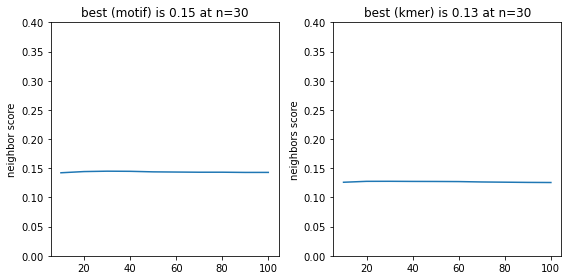

In [10]:
toplot = pd.read_csv('eval.csv', index_col=0)

f, axs = plt.subplots(figsize=(8, 4), ncols=2)
toplot['motif'].plot.line(ax=axs[0])
toplot['kmer'].plot.line(ax=axs[1])

best_n = pcs[toplot['motif'].argmax()]
best_val = toplot['motif'].max()
axs[0].set_ylabel('neighbor score')
axs[0].set_title('best (motif) is %.2f at n=%d'%(best_val, best_n))
axs[0].set_ylim(0, 0.4)

best_n = pcs[toplot['kmer'].argmax()]
best_val = toplot['kmer'].max()
axs[1].set_ylabel('neighbors score')
axs[1].set_title('best (kmer) is %.2f at n=%d'%(best_val, best_n))
axs[1].set_ylim(0, 0.4)

f.tight_layout()
f.savefig('eval.pdf')

### save

In [11]:
embed = pd.read_csv('embed_motif.csv', index_col=0).values
pd.DataFrame(embed[:,:30]).to_csv('projection_motif.csv')

embed = pd.read_csv('embed_kmer.csv', index_col=0).values
pd.DataFrame(embed[:,:30]).to_csv('projection_kmer.csv')

### plot

/home/yuanh/.local/lib/python3.7/site-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/yuanh/.local/lib/python3.7/site-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


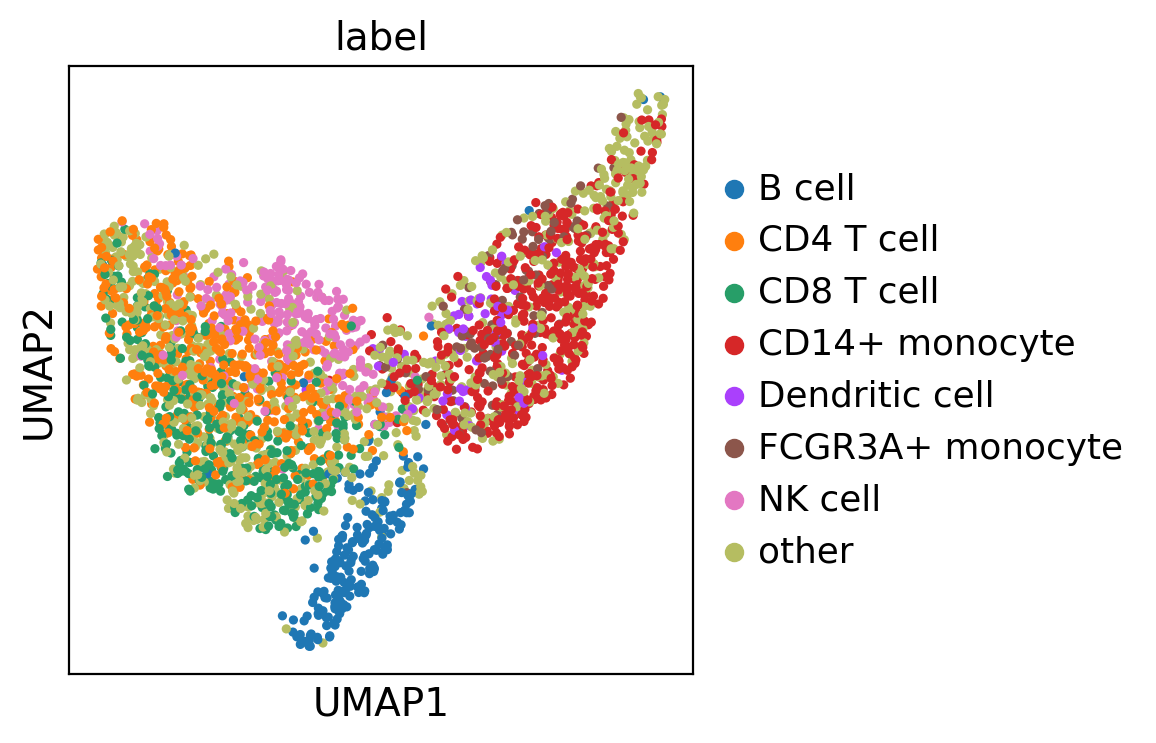

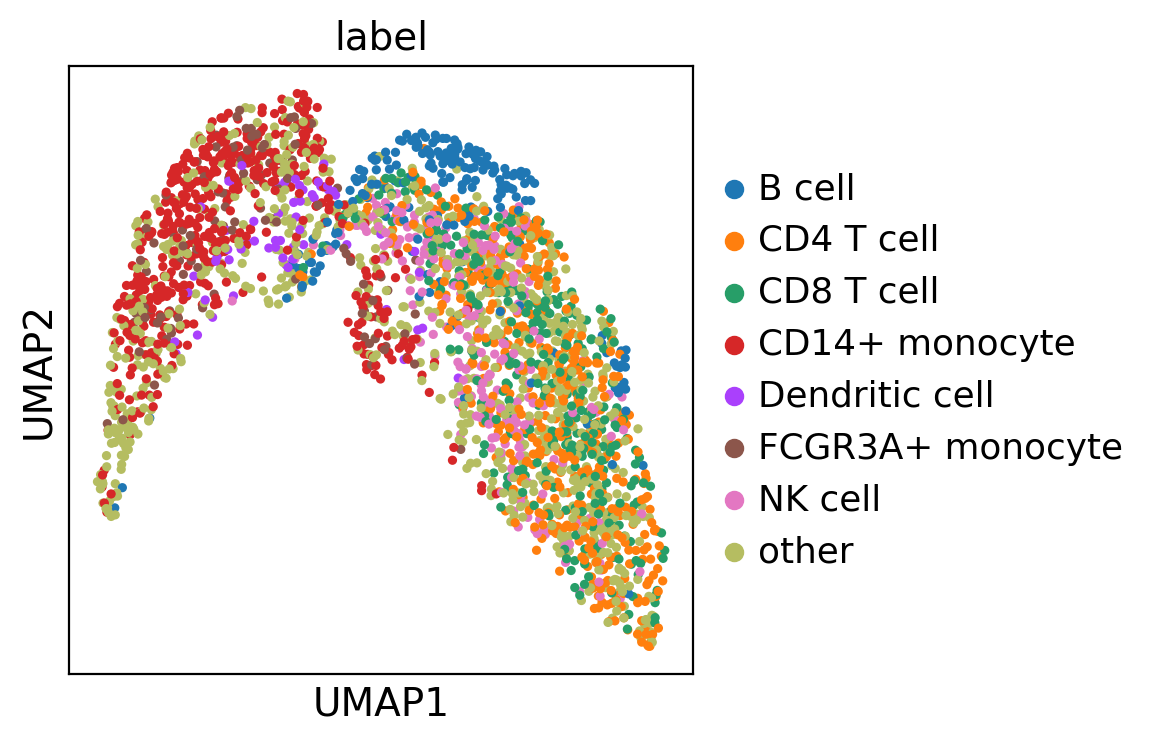

In [3]:
ad_atac = anndata.read_h5ad('/home/yuanh/sc_basset/datasets/10x_ARC_PBMC/ad_atac.h5ad')
ad_rna = anndata.read_h5ad('/home/yuanh/sc_basset/10x_ARC_PBMC/adam_32/interpret/annotation/ad_scvi_annotate.h5ad')
ad_atac.obs['label']=ad_rna.obs['cell_type']

sc.set_figure_params(vector_friendly=True, format='pdf', dpi=100)
ad_atac.obsm['projection'] = pd.read_csv('projection_motif.csv', index_col=0).values
sc.pp.neighbors(ad_atac, use_rep='projection')
sc.tl.umap(ad_atac)

f = sc.pl.umap(ad_atac, color=['label'], return_fig=True)
f.savefig('umap_label_motif.pdf')


sc.set_figure_params(vector_friendly=True, format='pdf', dpi=100)
ad_atac.obsm['projection'] = pd.read_csv('projection_kmer.csv', index_col=0).values
sc.pp.neighbors(ad_atac, use_rep='projection')
sc.tl.umap(ad_atac)

f = sc.pl.umap(ad_atac, color=['label'], return_fig=True)
f.savefig('umap_label_kmer.pdf')